## Import Toolkit

In [1]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint

#Warnings
import warnings
warnings.filterwarnings('ignore')

## Upload Data

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import os
# os.chdir('/content/drive/MyDrive/5_AIADVANCE')

In [4]:
# root_dir = '/content/drive/MyDrive/5_AIADVANCE/GK_AI_Advance/'
root_dir = 'Dataset'

# Đường dẫn tới thư mục con 'train', 'val' và 'test'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

In [5]:
img_size = (224 , 224)
batch_size = 8
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 1399 images belonging to 2 classes.


Found 399 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [37]:
print(train_gen.class_indices)
print(train_gen.samples)
print(train_gen.batch_size)
batch_data, batch_labels = next(train_gen)
# print(batch_data, batch_labels)
print(batch_data.shape)
print(batch_data[0].shape)
# print(train_gen.train_gen.samples // train_gen.batch_size,)

{'cat': 0, 'dog': 1}
1399
8
(8, 224, 224, 3)
(224, 224, 3)


In [40]:
print(batch_data[0])

[[[252. 246. 222.]
  [236. 234. 211.]
  [240. 242. 220.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 250. 228.]
  [238. 236. 215.]
  [238. 240. 219.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 236.]
  [240. 237. 218.]
  [229. 232. 213.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[163. 178. 209.]
  [129. 142. 174.]
  [134. 145. 177.]
  ...
  [ 94.  90.  91.]
  [102.  98.  99.]
  [108. 102. 102.]]

 [[119. 133. 168.]
  [105. 119. 154.]
  [140. 150. 186.]
  ...
  [132. 126. 128.]
  [ 96.  92.  93.]
  [121. 115. 115.]]

 [[129. 145. 179.]
  [129. 145. 179.]
  [159. 171. 209.]
  ...
  [130. 121. 124.]
  [139. 133. 135.]
  [126. 120. 120.]]]


## Show Sample From Train Data

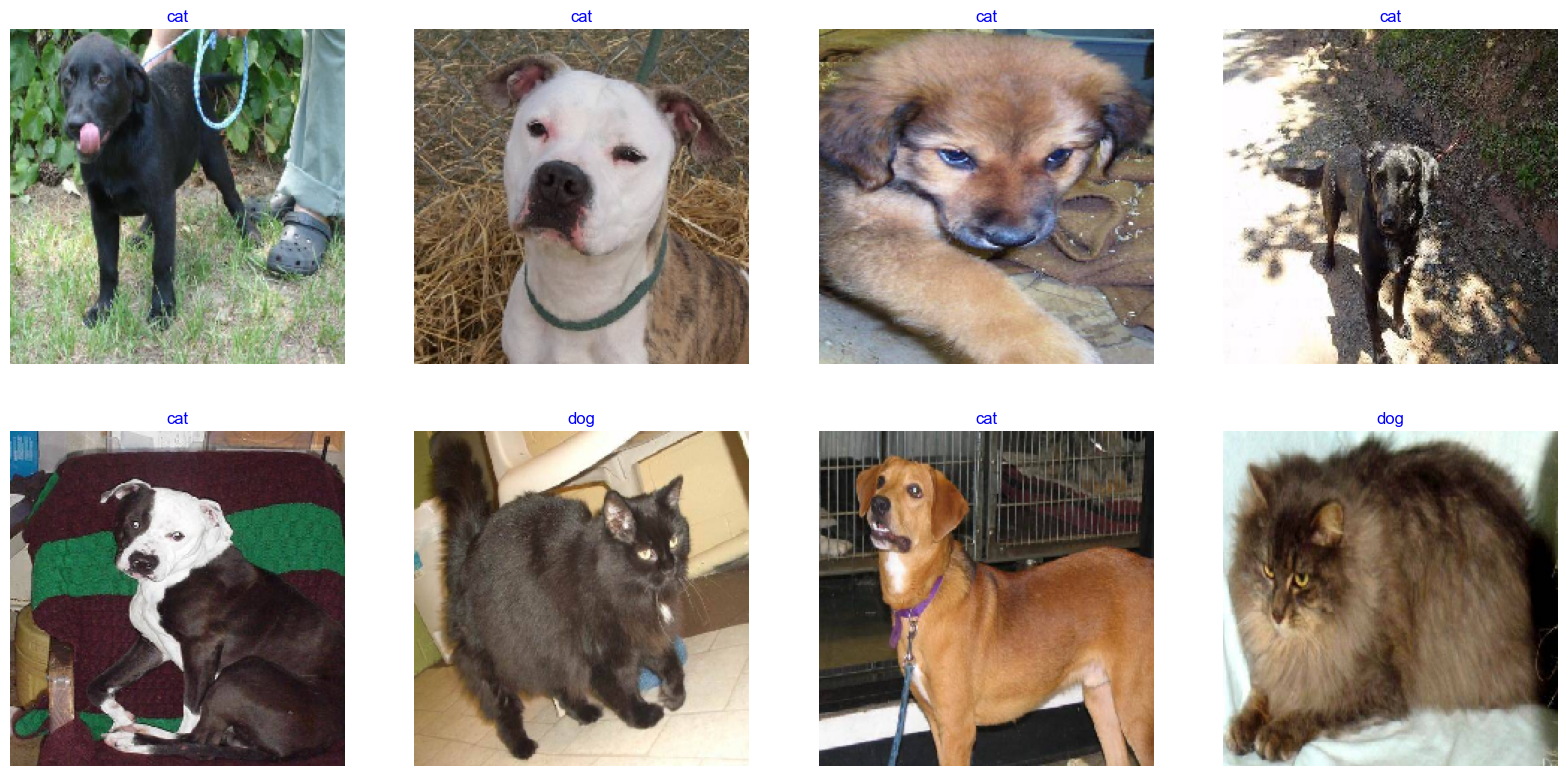

In [6]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    # class_index = int(labels[i]) # binary 
    class_index = int(labels[i][0]) # categorical
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

## Model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, DepthwiseConv2D, Add, GlobalAveragePooling2D, Reshape, Dropout, Dense
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

def swish(x):
    return x * Activation('sigmoid')(x)

def efficientnet_block(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer=he_normal(), kernel_regularizer=l2(1e-5))(inputs)
    x = BatchNormalization()(x)
    x = swish(x)
    return x

def mb_conv_block(inputs, filters, kernel_size, strides, expand_ratio):
    depth_filters = round(filters * expand_ratio)
    x = efficientnet_block(inputs, depth_filters, (1, 1), (1, 1))
    x = DepthwiseConv2D(kernel_size, strides=strides, padding='same', depthwise_initializer=he_normal(), depthwise_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = swish(x)
    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same', kernel_initializer=he_normal(), kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    if strides == (1, 1):
        x = Add()([inputs, x])
    return x

def build_efficientnet_b7(input_shape=(224, 224, 3), num_classes=1000, dropout_rate=0.2):
    inputs = Input(shape=input_shape)

    # Define block arguments
    blocks_args = [
        {'kernel_size': 3, 'repeats': 1, 'filters': 16, 'expand_ratio': 1, 'strides': 1},
        {'kernel_size': 3, 'repeats': 2, 'filters': 24, 'expand_ratio': 6, 'strides': 2},
        {'kernel_size': 5, 'repeats': 2, 'filters': 40, 'expand_ratio': 6, 'strides': 2},
        {'kernel_size': 3, 'repeats': 3, 'filters': 80, 'expand_ratio': 6, 'strides': 2},
        {'kernel_size': 5, 'repeats': 3, 'filters': 112, 'expand_ratio': 6, 'strides': 1},
        {'kernel_size': 5, 'repeats': 4, 'filters': 192, 'expand_ratio': 6, 'strides': 2},
        {'kernel_size': 3, 'repeats': 1, 'filters': 320, 'expand_ratio': 6, 'strides': 1}
    ]

    # Building the stem
    x = efficientnet_block(inputs, 64, (3, 3), strides=(2, 2))

    # Building blocks
    for block_args in blocks_args:
        num_repeat = block_args.pop('repeats')
        for _ in range(num_repeat):
            x = mb_conv_block(x, **block_args)

    # Building the head
    x = Conv2D(2560, (1, 1), padding='same', kernel_initializer=he_normal(), kernel_regularizer=l2(1e-5))(x)
    x = BatchNormalization()(x)
    x = swish(x)

    x = GlobalAveragePooling2D()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    x = Dense(num_classes, activation='softmax', kernel_initializer=he_normal(), kernel_regularizer=l2(1e-5))(x)

    # Create model
    model = Model(inputs, x, name='EfficientNetB7')

    return model

# Create EfficientNet B7 model
effnet_b7_model = build_efficientnet_b7(num_classes = 2)
# effnet_b7_model.summary()

In [8]:
# Tạo đối tượng optimizer  # SGD
optimizer = tf.keras.optimizers.Adam()

# Thiết lập ModelCheckpoint
save_best_only = True
# checkpoint = ModelCheckpoint('models/model-Effnet_b7_model-{epoch:03d}.keras',
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=save_best_only,
#                              mode='auto')

# Xây dựng quy trình huấn luyện
effnet_b7_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã chuẩn bị
H = effnet_b7_model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // train_gen.batch_size,
    validation_data = valid_gen,
    validation_steps = valid_gen.samples // valid_gen.batch_size,
    epochs = 5,
    # callbacks=[checkpoint]
)

Epoch 1/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 91s 412ms/step - accuracy: 0.5301 - loss: 1.6327 - val_accuracy: 0.5128 - val_loss: 0.9992
Epoch 2/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.4475 - val_accuracy: 0.4286 - val_loss: 0.5023
Epoch 3/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 70s 403ms/step - accuracy: 0.5325 - loss: 1.1882 - val_accuracy: 0.5077 - val_loss: 0.9988
Epoch 4/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.6250 - loss: 0.5539 - val_accuracy: 0.7143 - val_loss: 0.4966
Epoch 5/5
174/174 ━━━━━━━━━━━━━━━━━━━━ 67s 387ms/step - accuracy: 0.5430 - loss: 1.1497 - val_accuracy: 0.5128 - val_loss: 0.9979


## Model Performance

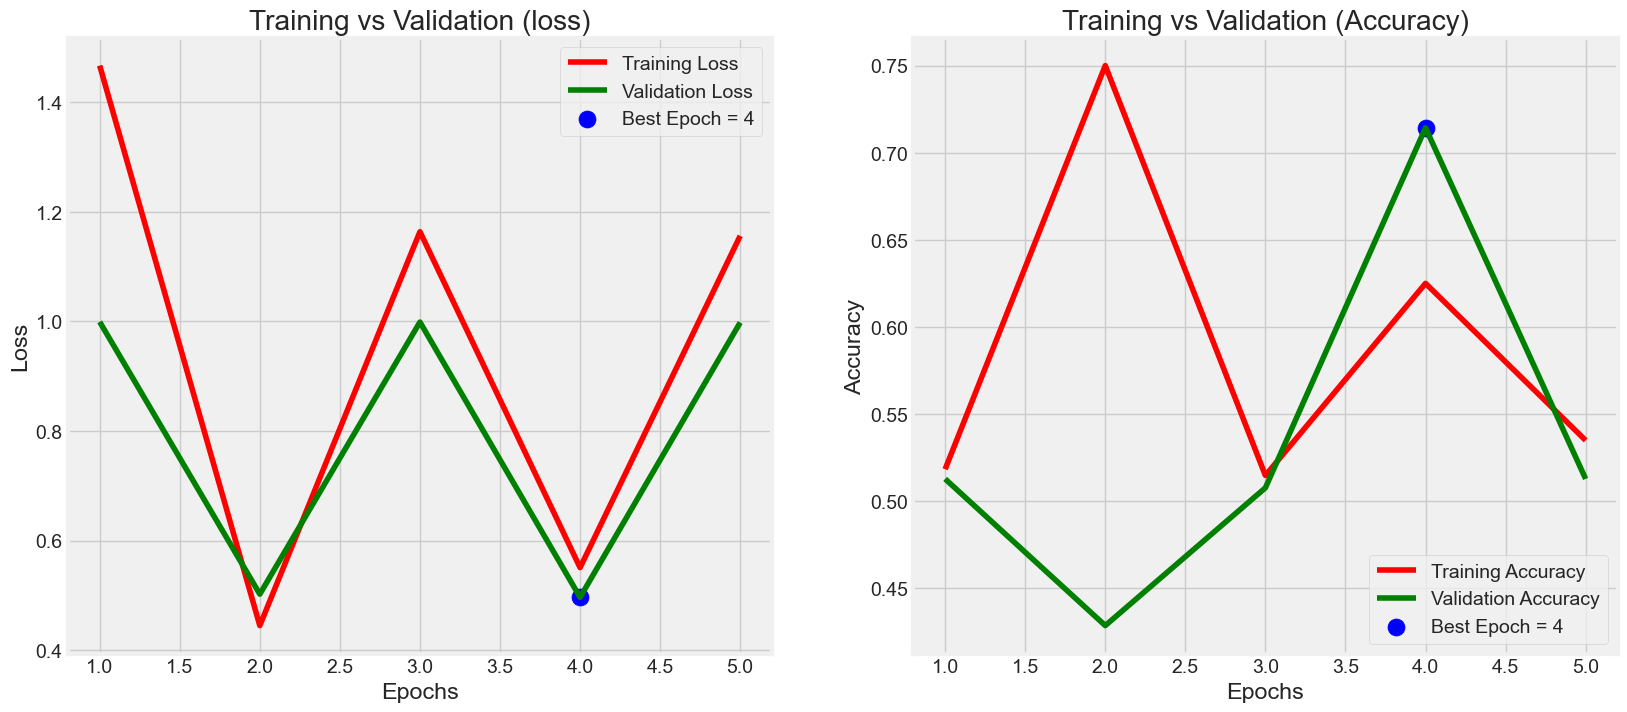

In [9]:
train_acc = H.history['accuracy']
train_loss = H.history['loss']

val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Model Evaluation

In [10]:
train_score = effnet_b7_model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = effnet_b7_model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = effnet_b7_model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.4865 - loss: 0.9983
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.5519 - loss: 0.9974
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.2422 - loss: 0.9946
Train loss = 0.9982067942619324
Train Accuracy = 0.4921875
Validation loss = 0.9976769089698792
Validation Accuracy = 0.53125
Test loss = 0.9608199596405029
Test Accuracy = 0.5099009871482849


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán
preds = effnet_b7_model.predict(test_gen)
print(preds)
preds = np.argmax(preds, axis=1)

# Lấy nhãn thật
true_labels = test_gen.classes

# Tính các chỉ số
report = classification_report(true_labels, preds, output_dict=True)

# In chỉ số f1, precision, recall
print("F1:", report['weighted avg']['f1-score'])
print("Precision:", report['weighted avg']['precision'])
print("Recall:", report['weighted avg']['recall'])

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
[[0.49660787 0.5033921 ]
 [0.4966076  0.5033924 ]
 [0.49660754 0.5033925 ]
 [0.49660838 0.50339156]
 [0.49660763 0.50339246]
 [0.49660805 0.50339186]
 [0.49660763 0.5033924 ]
 [0.49660796 0.503392  ]
 [0.49660784 0.5033921 ]
 [0.4966084  0.50339156]
 [0.49660826 0.5033917 ]
 [0.49660796 0.503392  ]
 [0.49660787 0.5033922 ]
 [0.49660844 0.5033915 ]
 [0.4966081  0.5033918 ]
 [0.49660808 0.5033919 ]
 [0.4966088  0.50339115]
 [0.4966078  0.5033921 ]
 [0.4966082  0.50339174]
 [0.4966077  0.5033924 ]
 [0.49660924 0.5033907 ]
 [0.49660838 0.50339156]
 [0.49660742 0.50339264]
 [0.49660793 0.503392  ]
 [0.4966091  0.50339085]
 [0.49660787 0.50339204]
 [0.49661142 0.5033886 ]
 [0.4966084  0.50339156]
 [0.49660787 0.5033921 ]
 [0.4966078  0.5033921 ]
 [0.49660787 0.5033922 ]
 [0.49660838 0.5033916 ]
 [0.49660861 0.5033914 ]
 [0.49660817 0.50339174]
 [0.49660802 0.5033919 ]
 [0.4966082  0.50339174]
 [0.49660838 0.50339156]
 [0.49660796 0.50339204]
 [0.496608

In [17]:
print(preds)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.51      1.00      0.68       103

    accuracy                           0.51       202
   macro avg       0.25      0.50      0.34       202
weighted avg       0.26      0.51      0.34       202



## Model Prediction

## Confusion Matrix and Classification Report

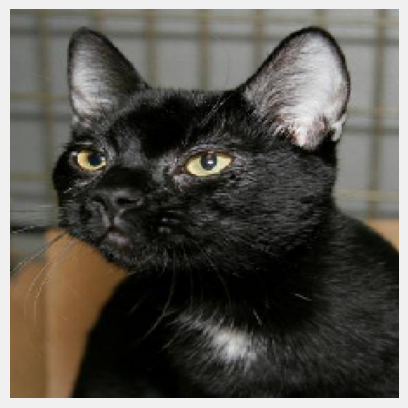

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
Dự đoán: 1


In [13]:
# Lấy 1 batch dữ liệu từ generator
batch = next(test_gen)
# In hình ảnh đầu tiên
img = batch[0][0]
img = img.astype(float)/255
plt.imshow(img)
plt.axis('off')
plt.show()

# Chuyển đổi thành 4D tensor
img = np.expand_dims(img, axis=0)

# Dự đoán
pred = effnet_b7_model.predict(img)
print('Dự đoán:', np.argmax(pred))

In [16]:
print(pred)

[[0.4966077  0.50339234]]


In [14]:
# Tính confusion matrix
conf_mat = confusion_matrix(true_labels, preds)

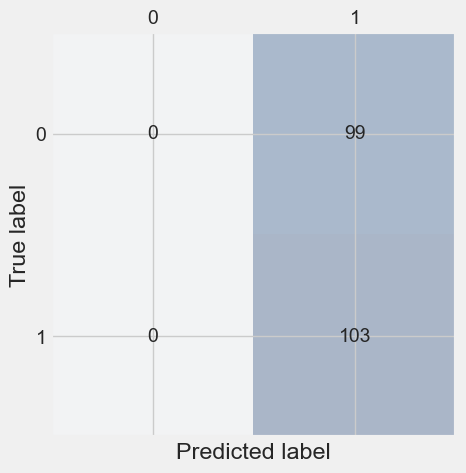

In [15]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i,j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()